In [ ]:
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install pyenchant
# !apt-get install libenchant1c2a

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing import sequence
import os 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

os.chdir('/content/drive/MyDrive/NeuralResearch/wine-net/')

# os.chdir('/content/drive/MyDrive/MSCA_31009/Final_Project/')

def remove_punctuation(s):
  punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

  # Removing punctuations in string
  # Using loop + punctuation string
  for ele in s:
      if ele in punc:
          s = s.replace(ele, "")
  return s

def clean_description(review, swap):
  terms = review.split()
  for x in terms:
    try: x = swap[('t_' + str(x))]
    except KeyError: x = ''
  return ' '.join(terms)


In [ ]:
wines = pd.read_csv('winemag-data-130k-v2.csv')
wines = wines.drop(columns = ['Unnamed: 0'])

wines2 = pd.read_csv('winemag-data_first150k.csv')
wines2.head()

# Intersect and append two review tables
columns = [value for value in wines.columns if value in wines2.columns] # intersection(wines.columns, wines2.columns)
wines = wines[columns]
wines2 = wines2[columns]
wines = pd.concat([wines, wines2]).drop(columns = ['designation', 'winery'])
wines['d_length'] = wines.description.apply(lambda x: len(str(x))).astype(int)

wines = wines[((wines.d_length > 75) & (wines.d_length < 450))]

wines = wines.sample(n=80000)

# Imputation steps
median_price = wines.price.median()
median_points = wines.points.median()

# Impute variables
wines.price = wines.price.fillna(median_price)
wines.points = wines.points.fillna(median_points)
wines = wines.fillna('')
wines.price = wines.price.astype(int)
wines.description = wines.description.apply(lambda x: remove_punctuation(x.lower()))

Y = wines.variety
output_shape = Y.nunique()
Y0_price = wines.price
Y1_points = wines.points.apply(lambda x: 1 if x > 90 else 0)

Y = [0 if wines['variety'].iloc[x] in ['Pinot Noir','Cabernet Sauvignon','Red Blend','Bordeaux-style Red Blend','Syrah','Merlot'] else 1 for x in range(len(wines['variety']))]
Y = pd.Series(Y)

wines = wines.drop(columns=['variety', 'price', 'points', 'region_1', 'region_2', 'd_length'])
wines.head()

,country,description,province,d_length
65051,US,this is the richest bottling of oppenlander th...,California,275
56862,Greece,tropical fruit aromas and flavors of mango van...,Central Greece,228
52548,US,very dry and tannicly tart with blackberry cur...,California,163
41793,France,ripe notes of juicy yellowpear waft from the g...,Alsace,156
133762,Spain,this albariño grows on you right away the wine...,Galicia,292


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


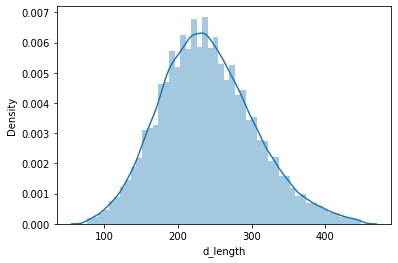

In [ ]:
sns.distplot(wines.d_length)

In [ ]:
text = wines.description
tfidf = TfidfVectorizer() 
review_vector = tfidf.fit_transform(text)
words = tfidf.get_feature_names_out()
rev_array = review_vector.toarray()
words_df = pd.DataFrame(rev_array, columns = words)

num_words = words.shape

import enchant
enchant.list_languages()
eng = enchant.Dict("en_US")
drops = []
for column in words_df.columns:
    english = eng.check(column)
    if any(map(str.isdigit, column)): 
        drops.append(column)
    if not(english):
        drops.append(column)
words_df = words_df.drop(columns = drops)
reduced_words = len(words_df.columns)
print('Reduced words by ', str(round(1-reduced_words/num_words,2)*100)
print('Reduced word count: ', str(reduced_words))
words_df.head()

(34496,)

In [ ]:
from keras.preprocessing.text import Tokenizer
X = wines.description.to_numpy()
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X)
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)
max_log_length = 1024
X_processed = sequence.pad_sequences(X, maxlen=max_log_length)
X_processed

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(Y)
Y_processed = encoder.transform(Y)
Y_processed = Y.to_numpy()

array([[   0,    0,    0, ...,  173,  265,  927],
       [   0,    0,    0, ...,   71,  361, 1094],
       [   0,    0,    0, ...,  563,    1, 1321],
       ...,
       [   0,    0,    0, ..., 5849, 2011,    9],
       [   0,    0,    0, ...,  536, 1392, 5463],
       [   0,    0,    0, ...,   25,   70,  442]], dtype=int32)

## Variety Classifier

In [ ]:
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_processed, test_size=0.25, random_state=0)

Y.value_counts()
input_dim = X_train.shape[1]

## RNN Build I

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=num_words, output_dim=1024,input_length=max_log_length))
model.add(tf.keras.layers.LSTM(units=32, recurrent_dropout=0.5))
model.add(tf.keras.layers.Dense(units=64,activation='relu'))
model.add(tf.keras.layers.Dense(units=32,activation='relu'))
model.add(tf.keras.layers.Dense(units=1,activation='relu'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 1024)        38333440  
                                                                 
 lstm (LSTM)                 (None, 32)                135296    
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 38,472,961
Trainable params: 38,472,961
Non-trainable params: 0
_________________________________________________________________


## RNN Build II

In [ ]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=num_words, output_dim=1024,input_length=max_log_length))
model2.add(tf.keras.layers.LSTM(units=32, recurrent_dropout=0.5))
model2.add(tf.keras.layers.Dense(units=1,activation='relu'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
model2.summary()

## CNN Build

In [ ]:
model.fit(x=X_train, y = y_train, batch_size = 256, epochs = 3)

Epoch 1/3
235/235 [==============================] - 1343s 6s/step - loss: 0.6319 - accuracy: 0.6766
Epoch 2/3
 17/235 [=>............................] - ETA: 21:05 - loss: 0.3874 - accuracy: 0.8284

In [ ]:
model.evaluate(X_test, y_test, batch_size=256)

In [ ]:
model2.fit(x=X_train, y = y_train, batch_size = 256, epochs = 3)

In [ ]:
model.evaluate(X_test, y_test, batch_size=256)